หากต้องการใช้ไลบรารีสนับสนุน mlxtend (https://github.com/rasbt/mlxtend) 
สำหรับพล็อตเส้นแสดงเขตการจำแนก สามารถติดตั้งไลบรารีโดยรันเซลล์ด้านล่าง

In [ ]:
#!pip install mlxtend

นำเข้าไลบรารีทั้งหมดที่ใช้งาน

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.io import loadmat
import sklearn
import sklearn.datasets
from mlxtend.plotting import plot_decision_regions

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

ตัวอย่างนี้ใช้ข้อมูลในแบบฝึกหัดสัปดาห์แรกของคอร์สออนไลน์ 
"Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization" 
โดย Prof.Andrew NG สำหรับผู้สนใจสามารถลงทะเบียนเรียนได้ที่ Coursera 
ในแบบฝึกหัดเพิ่มความน่าสนใจของโจทย์เป็นตำแหน่งผู้เล่น 2 
ทีมที่มีโอกาสโหม่งลูกฟุตบอลเมื่อผู้รักษาประตูเตะลูกมาในสนาม แต่โดยหลักการแล้วคือการจำแนกทวิภาคของข้อมูล 
2 กลุ่มในระนาบสองมิติ ในการสร้างและฝึกโมเดลจะใช้โค้ดไพธอนเช่นเดียวกับในบทที่ 2 
ผู้เรียนต้องเพิ่มส่วนเรกูลาร์ไรเซชัน (3.3) ลงในโค้ด ซึ่งสามารถทำให้เข้าใจได้อย่างถ่องแท้ 
แม้ว่าจะต้องอาศัยประสบการณ์การพัฒนาโปรแกรมโดยภาษาไพธอนอยู่พอสมควร ดังนั้นสำหรับในตัวอย่างนี้เราจะใช้ไลบรารี TF 
สร้างโมเดล DNN ซึ่งมีตัวเลือกในการทำเรกูลาร์ไรเซชันให้กับแต่ละชั้นของโมเดล

ข้อมูลถูกเก็บในไฟล์ "data.mat" ที่เราจะใส่ในไดเรคทอรี "datasets/" 
เขียนฟังก์ชัน ex31_load_data() เพื่อโหลดข้อมูลฝึกและทดสอบเข้าสู่แอเรย์พร้อมกับพล็อตในระนาบ 2 
มิติดังแสดงในรูปที่ 3.3

In [4]:
def ex31_load_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X']
    train_Y = data['y']
    test_X = data['Xval']
    test_Y = data['yval']
    for i in range(len(train_Y)):
        if train_Y[i,0] == 1:
            plt.scatter(train_X[i,0],train_X[i,1],c='orange', marker='^',s=40)
        else:
            plt.scatter(train_X[i,0],train_X[i,1],c='blue', marker='s',s=40)
    return train_X, train_Y, test_X, test_Y

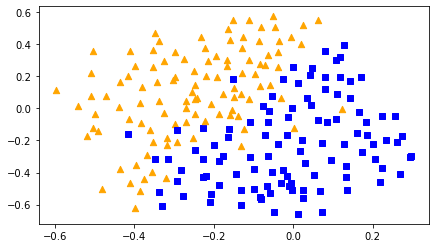

In [5]:
train_X, train_Y, test_X, test_Y = ex31_load_dataset()

รูปที่ 3.3 ข้อมูลสองมิติที่ต้องการจำแนกในตัวอย่าง 3.1

แอเรย์ข้อมูลที่คืนจากฟังก์ชัน ex31_load_dataset() เป็นชุดฝึก 211 จุดและชุดทดสอบ 200 จุด จากการประมาณโดยสายตา 
ข้อมูลในระนาบ 2 มิติในรูปที่ 3.3 สามารถถูกจำแนกได้โดยเส้นตรงในแนวทแยงมุม 
โดยพิจารณาจุดที่หลุดออกไปไกลจากกลุ่มเป็นเสมือนการรบกวน แต่โมเดลที่มีความแปรปรวนสูงจะมีแนวโน้มฟิตเกิน 
คือให้ความสำคัญกับจุดที่เป็นการรบกวนมากเกินไป 

เริ่มต้นโดยสร้างโมเดล DNN 3 ชั้นที่มีจำนวนเซลล์ 20, 30, 1 เป็นเส้นฐาน (baseline) โดยใช้ไลบรารี TF ดังนี้

In [6]:
model = Sequential([
    Flatten(input_shape=[2]),
    Dense(20, activation='relu'),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

คอมไพล์โมเดลตามรูปแบบการจำแนกทวิภาคที่ได้อธิบายในบทที่ 2 ผู้อ่านสามารถปรับอัตราการเรียนรู้ตามต้องการ

In [7]:
model.compile(optimizer=SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

ฝึกโมเดลจำนวน 10000 รอบ เก็บข้อมูลฝึกในดิกชันนารี history (ตัวเลือก batch_size=None กำหนดเพื่อมิให้มีการแบ่งข้อมูลเป็นกลุ่มเล็ก 
ซึ่งจะได้กล่าวถึงต่อไปในบทนี้)

In [8]:
history = model.fit(train_X, train_Y, epochs=10000, batch_size=None, validation_data=(test_X,test_Y),verbose=0)

เพื่อความสะดวกจะสร้างฟังก์ชันสำหรับพล็อตความแม่นยำและค่าสูญเสีย โดยสามารถเรียกใช้ในตัวอย่างอื่นที่จะนำเสนอต่อไป

In [18]:
def plot_acc_loss(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc)) # Get number of epochs

    acc_txt = str(round(acc[len(acc)-1]*100,2))
    val_acc_txt = str(round(val_acc[len(val_acc)-1]*100,2))

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(epochs, acc,'r',epochs,val_acc,'b')
    ax1.set_title('Training and validation accuracy')
    ax1.legend(["Training acc = "+acc_txt+" %","Validation acc = "+val_acc_txt+" %"])

    loss_txt = str(round(loss[len(loss)-1],2))
    val_loss_txt = str(round(val_loss[len(val_loss)-1],2))

    ax2.plot(epochs, loss, 'r',epochs, val_loss, 'b')
    ax2.legend(["Training loss = "+loss_txt,"Validation loss = "+val_loss_txt])
    ax2.set_title('Training and validation loss');


พล็อตความแม่นยำจากชุดข้อมูลฝึกและทดสอบดังแสดงในรูปที่ 3.4 

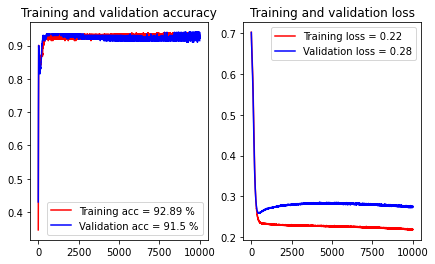

In [11]:
plot_acc_loss(history)

รูปที่ 3.4 ความแม่นยำและค่าสูญเสียจากโมเดลเส้นฐาน

สามารถสังเกตผลจากการฟิตเกินได้ในพล็อตของค่าสูญเสียทางด้านขวาของรูปที่ 3.4 
โดยขณะที่ค่าสูญเสียจากข้อมูลฝึกลดลงต่อเนื่องตามจำนวนรอบการฝึก 
ค่าสูญเสียจากข้อมูลทดสอบกลับมีแนวโน้มเพิ่มขึ้น
เมื่อพล็อตเส้นแบ่งเขตเพื่อตรวจสอบสมรรถนะการจำแนกข้อมูลจากโมเดลเส้นฐานจะได้ดังในรูปที่ 3.5


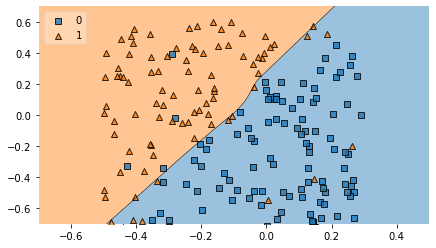

In [12]:
plot_decision_regions(test_X, np.squeeze(test_Y), clf=model, legend=2)
plt.xlim([-0.7,0.5])
plt.ylim([-0.7,0.7])
plt.show()

รูปที่ 3.5 เส้นแบ่งเขตการจำแนกข้อมูลจากโมเดลเส้นฐาน


### 3.2.3 การแก้ปัญหาฟิตเกินรูปแบบอื่น

ในหัวข้อย่อยนี้จะกล่าวถึงวิธีการแก้ปัญหาฟิตเกินที่นอกเหนือจากการทำเรกูลาร์ไรเซชันและดรอปเอาต์ แนวทางแรกคือการเพิ่มข้อมูลฝึก
หลักการของการเรียนรู้เชิงลึกคือการขับเคลื่อนโดยข้อมูล ในกรณีที่ไม่สามารถหาข้อมูลใหม่มาเพิ่มเติมได้ เราสามารถที่จะใช้การแต่งเติมข้อมูล (data augmentation) 
กับข้อมูลเดิมที่มีอยู่เพื่อเพิ่มความหลากหลายให้กับข้อมูลฝึก ตัวอย่างเช่นในการจำแนกภาพสุนัขและแมว 
อาจจะใช้โปรแกรมด้านการประมวลผลภาพเพื่อกลับองค์ประกอบจากซ้ายมาขวา (เหมือนมองผ่านกระจกเงา) ขยาย ย่อ หรือหมุนภาพ ไลบรารี TF 
มีฟังก์ชันสนับสนุนเพื่อช่วยในการแต่งเติมข้อมูลฝึกได้โดยง่าย

อีกวิธีการหนึ่งที่สามารถลดการฟิตเกินได้โดยไม่ต้องแก้ไขโมเดลหรือข้อมูลคือการตรวจสอบค่าสูญเสียของชุดข้อมูลฝึกและชุดข้อมูลทดสอบในระหว่างการฝึก 
และหยุดการฝึกเมื่อค่าสูญเสียของชุดข้อมูลทดสอบมีแนวโน้มเพิ่มขึ้นแม้ว่าค่าสูญเสียของชุดข้อมูลฝึกยังลดลงดังแสดงในรูปที่ 3.11 
เพราะการฝึกโมเดลต่อไปหลังจากจุดนี้ทำให้เกิดการฟิตเกิน หากใช้ไลบรารี TF เราสามารถกำหนดฟังก์ชันเรียกกลับเพื่อหยุดการฝึกได้โดยง่าย

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=19rXgC5tWMa4H0bWAvgRCTcMzS5PvrTm9" width=550 />
</p>
<div align="center">รูปที่ 3.11 วิธีการหยุดฝึกตั้งแต่ช่วงต้น</div>

**ตัวอย่าง 3.3**

จากโมเดลเส้นฐานในตัวอย่าง 3.1 ต้องการใช้ฟังก์ชันเรียกกลับเพื่อหยุดการฝึกเมื่อค่าสูญเสียจากชุดข้อมูลทดสอบมีแนวโน้มเพิ่มขึ้น 
ในทางปฏิบัติค่าสููญเสียอาจมีการรบกวนทำให้มีค่าเปลี่ยนแปลงขึ้นลงไม่สม่ำเสมอ ดังนั้นต้องมีการกรองการกระเพื่อมดังกล่าว

นำเข้าฟังก์ชัน EarlyStopping ได้ดังนี้

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

สร้างและคอมไพล์โมเดลเส้นฐานโดยใช้คำสั่งเช่นเดียวกับในตัวอย่าง 3.1

In [26]:
model_ES = Sequential([
    Flatten(input_shape=[2]),
    Dense(20, activation='relu'),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model_ES.compile(optimizer=SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

เขียนโค้ดเพื่อสร้างฟังก์ชันเรียกกลับเป็น EarlyStopping() ใส่อาร์กิวเมนต์เพื่อเฝ้าสังเกตค่าสูญเสีย val_loss และตั้งค่า 
patience เพื่อกำหนดว่าจะหยุดการฝึกเมื่อค่าสูญเสียเพิ่มขึ้นเป็นจำนวนกี่รอบ 

In [27]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5)

ฝึกโมเดลโดยตั้ง callbacks เป็น [early_stopping] (ต้องอยู่ในวงเล็บสี่เหลี่ยมเนื่องจากอาจมีการเรียกกลับหลายฟังก์ชัน) 

In [28]:
history_ES = model_ES.fit(train_X, train_Y, epochs=10000,batch_size=None,validation_data=(test_X,test_Y),callbacks=[early_stopping])

Epoch 1/10000
7/7 [==============================] - 0s 17ms/step - loss: 0.6795 - accuracy: 0.6825 - val_loss: 0.6758 - val_accuracy: 0.7350
Epoch 2/10000
7/7 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.6825 - val_loss: 0.6742 - val_accuracy: 0.7750
Epoch 3/10000
7/7 [==============================] - 0s 4ms/step - loss: 0.6770 - accuracy: 0.7346 - val_loss: 0.6727 - val_accuracy: 0.7750
Epoch 4/10000
7/7 [==============================] - 0s 4ms/step - loss: 0.6758 - accuracy: 0.7583 - val_loss: 0.6713 - val_accuracy: 0.7700
Epoch 5/10000
7/7 [==============================] - 0s 4ms/step - loss: 0.6746 - accuracy: 0.7536 - val_loss: 0.6698 - val_accuracy: 0.7700
Epoch 6/10000
7/7 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.7488 - val_loss: 0.6684 - val_accuracy: 0.7700
Epoch 7/10000
7/7 [==============================] - 0s 4ms/step - loss: 0.6720 - accuracy: 0.7488 - val_loss: 0.6670 - val_accuracy: 0.7700
Epoch 8/1000

Epoch 59/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.5843 - accuracy: 0.8294 - val_loss: 0.5698 - val_accuracy: 0.8000
Epoch 60/10000
7/7 [==============================] - 0s 4ms/step - loss: 0.5821 - accuracy: 0.8294 - val_loss: 0.5674 - val_accuracy: 0.8000
Epoch 61/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.5800 - accuracy: 0.8294 - val_loss: 0.5651 - val_accuracy: 0.8000
Epoch 62/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.8246 - val_loss: 0.5626 - val_accuracy: 0.8000
Epoch 63/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.5756 - accuracy: 0.8294 - val_loss: 0.5605 - val_accuracy: 0.8000
Epoch 64/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.5735 - accuracy: 0.8294 - val_loss: 0.5582 - val_accuracy: 0.8050
Epoch 65/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.5713 - accuracy: 0.8294 - val_loss: 0.5559 - val_accuracy: 0.8050
Epoch 

7/7 [==============================] - 0s 3ms/step - loss: 0.3505 - accuracy: 0.8720 - val_loss: 0.3421 - val_accuracy: 0.8950
Epoch 174/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.3491 - accuracy: 0.8720 - val_loss: 0.3408 - val_accuracy: 0.9000
Epoch 175/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.3480 - accuracy: 0.8720 - val_loss: 0.3395 - val_accuracy: 0.9000
Epoch 176/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.3465 - accuracy: 0.8720 - val_loss: 0.3384 - val_accuracy: 0.9000
Epoch 177/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.3452 - accuracy: 0.8768 - val_loss: 0.3372 - val_accuracy: 0.9000
Epoch 178/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.3441 - accuracy: 0.8720 - val_loss: 0.3362 - val_accuracy: 0.9000
Epoch 179/10000
7/7 [==============================] - 0s 4ms/step - loss: 0.3426 - accuracy: 0.8673 - val_loss: 0.3352 - val_accuracy: 0.9000
Epoch 180/10000

7/7 [==============================] - 0s 3ms/step - loss: 0.2625 - accuracy: 0.9194 - val_loss: 0.2695 - val_accuracy: 0.9200
Epoch 288/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2622 - accuracy: 0.9194 - val_loss: 0.2693 - val_accuracy: 0.9200
Epoch 289/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2617 - accuracy: 0.9194 - val_loss: 0.2690 - val_accuracy: 0.9200
Epoch 290/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2613 - accuracy: 0.9194 - val_loss: 0.2688 - val_accuracy: 0.9200
Epoch 291/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2611 - accuracy: 0.9194 - val_loss: 0.2686 - val_accuracy: 0.9200
Epoch 292/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2614 - accuracy: 0.9194 - val_loss: 0.2684 - val_accuracy: 0.9200
Epoch 293/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2603 - accuracy: 0.9194 - val_loss: 0.2682 - val_accuracy: 0.9200
Epoch 294/10000

ตรวจสอบจากเอาต์พุตจะพบว่ามีการหยุดฝึกเมื่อผ่านไปได้เพียง 409 รอบ (การรันแต่ละครั้งอาจได้ค่าที่แตกต่างกัน) 
พล็อตค่าความแม่นยำ ค่าสูญเสีย และผลการจำแนกข้อมูลได้ดังรูปที่ 3.12, 3.13 
จะเห็นว่ามีผลคล้ายกับการทำเรกูลาร์ไรเซชันหรือดรอปเอาต์ คือสามารถลดการฟิตเกินลงได้

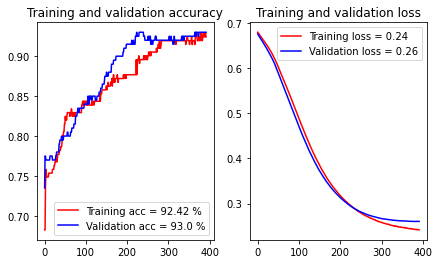

In [29]:
plot_acc_loss(history_ES)

รูปที่ 3.12 ความแม่นยำและค่าสูญเสียจากโมเดลที่หยุดการฝึกตั้งแต่ช่วงต้น

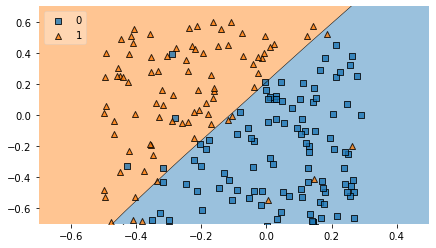

In [30]:
plot_decision_regions(test_X, np.squeeze(test_Y), clf=model_ES, legend=2)
plt.xlim([-0.7,0.5])
plt.ylim([-0.7,0.7])
plt.show()

รูปที่ 3.13 เส้นแบ่งเขตการจำแนกข้อมูลจากโมเดลที่หยุดการฝึกตั้งแต่ช่วงต้น

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>